importando drive

In [2]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pathlib


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D # Updated import statements
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from keras import metrics

In [5]:
data_dir = pathlib.Path("/content/drive/MyDrive/TCC_DOCS/images")
print(data_dir)

/content/drive/MyDrive/TCC_DOCS/images


In [ ]:
#resnet50

In [7]:
resnet50_img_size = 100
resnet50_batch_size = 150

resnet50_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(resnet50_img_size, resnet50_img_size),
    batch_size=resnet50_batch_size)

resnet50_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(resnet50_img_size,resnet50_img_size),
    batch_size=resnet50_batch_size)

resnet50_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(resnet50_img_size,resnet50_img_size),
    batch_size=resnet50_batch_size)

class_names = resnet50_test_ds.class_names

Found 47813 files belonging to 5 classes.
Found 47813 files belonging to 5 classes.
Using 9562 files for validation.
Found 47813 files belonging to 5 classes.


In [8]:
for image_batch, labels_batch in resnet50_train_ds:
  resnet50_train_img = image_batch
  resnet50_train_labels = labels_batch
  break
for image_batch, labels_batch in resnet50_val_ds:
  resnet50_val_img = image_batch
  resnet50_val_labels = labels_batch
  break
for image_batch, labels_batch in resnet50_test_ds:
  resnet50_test_img = image_batch
  resnet50_test_labels = labels_batch
  break

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

resnet50_train_ds = resnet50_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
resnet50_val_ds = resnet50_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
resnet50_test_ds = resnet50_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(resnet50_img_size,
                                                              resnet50_img_size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [11]:
#Restnet50
img_shape = (resnet50_img_size,resnet50_img_size,3)
Resnet50_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='avg',
    classes=5,
)
prediction_layer = tf.keras.layers.Dense(5,activation='relu',bias_regularizer=regularizers.l2(1e-4))

94765736/94765736 [==============================] - 1s 0us/step


In [12]:
num_classes = 5
resnet50_model = Sequential([
    data_augmentation,
    Resnet50_model,
    prediction_layer,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Activation('softmax'),
])

In [13]:
resnet50_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [14]:
epochs = 50
history = resnet50_model.fit(
  resnet50_train_ds,
  validation_data=resnet50_val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


319/319 [==============================] - 2861s 349ms/step - loss: 1.0045 - accuracy: 0.7476 - val_loss: 0.9538 - val_accuracy: 0.7052
Epoch 2/50
319/319 [==============================] - 69s 218ms/step - loss: 0.7757 - accuracy: 0.7863 - val_loss: 0.9755 - val_accuracy: 0.6927
Epoch 3/50
319/319 [==============================] - 69s 217ms/step - loss: 0.6664 - accuracy: 0.7972 - val_loss: 0.7397 - val_accuracy: 0.7495
Epoch 4/50
319/319 [==============================] - 69s 217ms/step - loss: 0.6041 - accuracy: 0.8044 - val_loss: 0.8013 - val_accuracy: 0.7669
Epoch 5/50
319/319 [==============================] - 69s 217ms/step - loss: 0.5629 - accuracy: 0.8109 - val_loss: 0.7838 - val_accuracy: 0.7422
Epoch 6/50
319/319 [==============================] - 69s 217ms/step - loss: 0.5322 - accuracy: 0.8153 - val_loss: 0.6873 - val_accuracy: 0.7491
Epoch 7/50
319/319 [==============================] - 69s 217ms/step - loss: 0.5104 - accuracy: 0.8213 - val_loss: 0.6571 - val_accuracy: 0

In [15]:
#Learning Rate Annealer Alexnet
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(   monitor='val_accuracy',   factor=.01,   patience=3,  min_lr=1e-5)

history = resnet50_model.fit(
  resnet50_train_ds,
  validation_data=resnet50_val_ds,
  epochs=epochs,
  callbacks=[lrr],
  verbose=1,
)

Epoch 1/50
319/319 [==============================] - 69s 217ms/step - loss: 0.0944 - accuracy: 0.9662 - val_loss: 0.2915 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 2/50
319/319 [==============================] - 69s 216ms/step - loss: 0.0911 - accuracy: 0.9679 - val_loss: 1.2430 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 3/50
319/319 [==============================] - 69s 216ms/step - loss: 0.0925 - accuracy: 0.9667 - val_loss: 0.3265 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 4/50
319/319 [==============================] - 69s 217ms/step - loss: 0.0875 - accuracy: 0.9692 - val_loss: 1.4561 - val_accuracy: 0.7527 - lr: 0.0010
Epoch 5/50
319/319 [==============================] - 69s 217ms/step - loss: 0.0691 - accuracy: 0.9770 - val_loss: 0.0991 - val_accuracy: 0.9659 - lr: 1.0000e-05
Epoch 6/50
319/319 [==============================] - 69s 217ms/step - loss: 0.0594 - accuracy: 0.9804 - val_loss: 0.0958 - val_accuracy: 0.9677 - lr: 1.0000e-05
Epoch 7/50
319/319 [========================

In [16]:
resnet50_loss, resnet50_acc = resnet50_model.evaluate(resnet50_test_ds)

319/319 [==============================] - 195s 597ms/step - loss: 0.0592 - accuracy: 0.9807


5/5 [==============================] - 2s 138ms/step


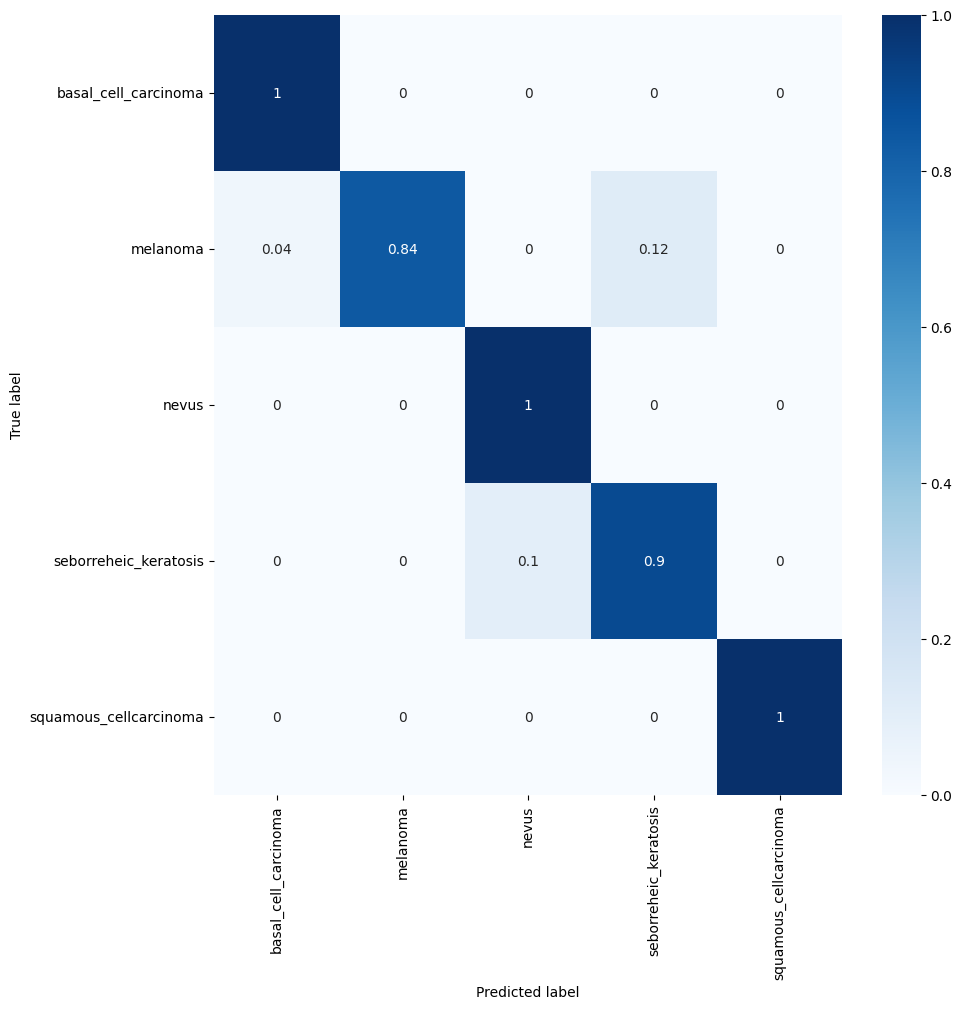

In [17]:
resnet50_y_pred=np.argmax(resnet50_model.predict(resnet50_test_img), axis=-1)
resnet50_con_mat = tf.math.confusion_matrix(labels=resnet50_test_labels, predictions=resnet50_y_pred).numpy()

resnet50_con_mat_norm = np.around(resnet50_con_mat.astype('float') / resnet50_con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

resnet50_con_mat_df = pd.DataFrame(resnet50_con_mat_norm,
                     index = class_names,
                     columns = class_names)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(resnet50_con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
resnet50_y_pred = resnet50_model.predict(resnet50_test_ds)
resnet50_predicted_categories = np.argmax(resnet50_y_pred, axis = 1)

resnet50_true_categories = tf.concat([y for x, y in resnet50_test_ds], axis = 0).numpy() # convert to np array

print(classification_report(resnet50_true_categories, resnet50_predicted_categories))

319/319 [==============================] - 18s 53ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4767
           1       0.96      0.94      0.95      7226
           2       0.99      0.99      0.99     32614
           3       0.94      0.96      0.95      1905
           4       0.97      0.93      0.95      1301

    accuracy                           0.98     47813
   macro avg       0.97      0.96      0.96     47813
weighted avg       0.98      0.98      0.98     47813

